# Acute Lymphoblastic Leukemia (ALL) Detection using Deep Learning

### Import libraries

In [1]:
# libraries for basic and preprocessing functions
import numpy as np
import pandas as pd
import os
import cv2
import shutil
import random
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
import random

2023-09-08 12:05:21.444744: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
SEED = 204

tf.random.set_seed(SEED)
np.random.seed(SEED)

### Loading dataset

In [3]:
# train set
all_0 = '/Users/rajasuvedhavivekanandan/C-NMC_Leukemia/training_data_fold/fold_0/all'
all_1 = '/Users/rajasuvedhavivekanandan/C-NMC_Leukemia/training_data_fold/fold_1/all'
all_2 = '/Users/rajasuvedhavivekanandan/C-NMC_Leukemia/training_data_fold/fold_2/all'

hem_0 = '/Users/rajasuvedhavivekanandan/C-NMC_Leukemia/training_data_fold/fold_0/hem'
hem_1 = '/Users/rajasuvedhavivekanandan/C-NMC_Leukemia/training_data_fold/fold_1/hem'
hem_2 = '/Users/rajasuvedhavivekanandan/C-NMC_Leukemia/training_data_fold/fold_2/hem'

# test set
test_dir = '/Users/rajasuvedhavivekanandan/C-NMC_Leukemia/testing_data'

In [4]:
# array for all images' paths
train_set = []

# function to get each image's path
def img_path(file_path):
    img_paths = []
    img_files = os.listdir(file_path)
    for img in img_files:
        if img.endswith(".bmp"):
            image = os.path.join(file_path, img)
            img_paths.append(image)
    return img_paths

# store each image's path to train_set
for f in [all_0, all_1, all_2, hem_0, hem_1, hem_2]:
    every_path = img_path(f)
    train_set.extend(every_path)

print("Total number of images in training set:", len(train_set))

Total number of images in training set: 10661


In [6]:
# directory for all training images
train_dir = '/Users/rajasuvedhavivekanandan/C-NMC_Leukemia/train_merged'
for path in train_set:
    filename = os.path.basename(path)
    train_path = os.path.join(train_dir, filename)
    shutil.copy(path, train_dir)

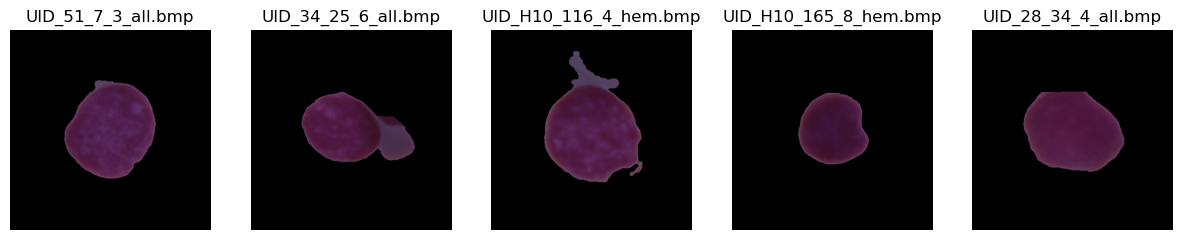

In [7]:
# display 5 random images
disp_img = random.sample(train_set, 5)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, img_path in enumerate(disp_img):
    image = cv2.imread(img_path)
    axes[i].imshow(image)
    axes[i].axis("off")
    label = img_path.split("/")[-1]
    axes[i].set_title(label)
plt.show()

In [89]:
from PIL import Image
size = []

for i in train_set:
    img = Image.open(i)

    # Get the original image size
    img_width, img_height = img.size
    size.append(img.size)

print(list(set(size)))

[(450, 450)]


### Prepocessing images

#### Cropping

In [8]:
def crop_imgs(train_dir):
    cropped_paths = []
    cropped_dir = '/Users/rajasuvedhavivekanandan/C-NMC_Leukemia/cropped_data'
    for image_name in os.listdir(train_dir):
        image_path = os.path.join(train_dir, image_name)
        image = cv2.imread(image_path)
        
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, threshold = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cell_border = 0
        border_contour = None
        for c in contours:
            if cv2.contourArea(c) > cell_border:
                cell_border = cv2.contourArea(c)
                border_contour = c
        (x, y, w, h) = cv2.boundingRect(c)
        cropped_image = image[y:y+h, x:x+w]
        
        cropped_path = os.path.join(cropped_dir, image_name)
        cv2.imwrite(cropped_path, cropped_image)
        cropped_paths.append(cropped_path)
    return cropped_paths

#### Resize

In [9]:
def resize_imgs(cropped_paths, resized_size):
    resized_paths = []
    resized_dir = '/Users/rajasuvedhavivekanandan/C-NMC_Leukemia/resized_data'
    for crop_path in cropped_paths:
        image = cv2.imread(crop_path)

        resized_image = cv2.resize(image, resized_size)

        resized_path = os.path.join(resized_dir, crop_path.split("/")[-1])
        cv2.imwrite(resized_path, resized_image)
        resized_paths.append(resized_path)
    return resized_paths

#### Noise

In [10]:
def add_noise(resized_paths):
    processed_paths = []
    processed_dir = '/Users/rajasuvedhavivekanandan/C-NMC_Leukemia/processed_data'
    for res_path in resized_paths:
        image = cv2.imread(res_path)

        noised_image = cv2.GaussianBlur(image, (5,5), 0)

        noised_path = os.path.join(processed_dir, 'proc_' + res_path.split("/")[-1])
        cv2.imwrite(noised_path, noised_image)
        processed_paths.append(noised_path)
    return processed_paths

#### Pre-processed data

In [11]:
def proc_imgs(train_dir, resized_size):
    cropped_paths = crop_imgs(train_dir)
    resized_paths = resize_imgs(cropped_paths, resized_size)
    proc_paths = add_noise(resized_paths)
    return proc_paths

In [12]:
resized_size = (128, 128)
proc_paths = proc_imgs(train_dir, resized_size)

### Data Augmentation

In [14]:
# assign class for normal(hem) and leukemic(all) cells
image_classes = []
for file in proc_paths:
    image_class = 1 if 'all' in file else 0
    image_classes.append(image_class)

len(image_classes)

10661

In [15]:
all_imgs = []
hem_imgs = []

for img in proc_paths:
    if 'all' in img:
        all_imgs.append(img)
    else:
        hem_imgs.append(img)

hem_needed = (len(proc_paths)//2) - len(hem_imgs)
all_remove = len(all_imgs) - (len(proc_paths)//2)

print(f"Number of HEM cells: {len(hem_imgs)}")
print(f"Number of ALL cells: {len(all_imgs)}")
print(f"Number of HEM cells needed: {hem_needed}")
print(f"Number of ALL cells to be removed: {all_remove}")

Number of HEM cells: 3389
Number of ALL cells: 7272
Number of HEM cells needed: 1941
Number of ALL cells to be removed: 1942


In [16]:
# array of random ALL cells to be removed
all_be_removed = random.sample(all_imgs, all_remove)
len(all_be_removed)

1942

In [17]:
# array of random hem images to be augmented
aug_hem = random.sample(hem_imgs, hem_needed)
len(aug_hem)

1941

In [18]:
def rot_imgs(hem_img, angle):
    processed_dir = '/Users/rajasuvedhavivekanandan/C-NMC_Leukemia/processed_data'
    image = cv2.imread(hem_img)

    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotated_image = cv2.warpAffine(image, M, (cols, rows))

    rot_path = os.path.join(processed_dir, 'rot_' + hem_img.split("/")[-1])
    cv2.imwrite(rot_path, rotated_image)
    return rot_path

def flip_imgs(hem_img, orientation):
    processed_dir = '/Users/rajasuvedhavivekanandan/C-NMC_Leukemia/processed_data'
    image = cv2.imread(hem_img)

    flipped_image = cv2.flip(image, orientation)

    flip_path = os.path.join(processed_dir, 'flip_' + hem_img.split("/")[-1])
    cv2.imwrite(flip_path, flipped_image)
    return flip_path

In [19]:
def random_aug(hem):
    counter = random.randint(1, 10)
    if counter > 5:
        hem = rot_imgs(hem, random.randint(90, 270))
    else:
        hem = flip_imgs(hem, random.randint(0,1))
    return hem

In [20]:
hem_added = []
for hem_img in aug_hem:
    augmented_hem = random_aug(hem_img)
    hem_added.append(augmented_hem)

len(hem_added)

1941

In [21]:
proc_paths.extend(hem_added)

In [22]:
for i in all_be_removed:
    proc_paths.remove(i)

In [23]:
len(proc_paths)

10660

In [24]:
all_imgs = []
hem_imgs = []

for img in proc_paths:
    if 'all' in img:
        all_imgs.append(img)
    else:
        hem_imgs.append(img)

hem_needed = (len(proc_paths)//2) - len(hem_imgs)
all_remove = len(all_imgs) - (len(proc_paths)//2)

print(f"Number of HEM cells: {len(hem_imgs)}")
print(f"Number of ALL cells: {len(all_imgs)}")
print(f"Number of HEM cells needed: {hem_needed}")
print(f"Number of ALL cells to be removed: {all_remove}")

Number of HEM cells: 5330
Number of ALL cells: 5330
Number of HEM cells needed: 0
Number of ALL cells to be removed: 0


### Splitting dataset into train, test and validation

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
# assign class for normal(hem) and leukemic(all) cells
image_classes = []
for file in proc_paths:
    image_class = 1 if 'all' in file else 0
    image_classes.append(image_class)

len(image_classes)

10660

In [27]:
# proc_paths = paths of every image
# convert to pixels array
image_pixels = []
for path in proc_paths:
    each_pix_arr = cv2.imread(path)
    image_pixels.append(each_pix_arr)

In [28]:
# images' pixels array as a numpy array
X = np.array(image_pixels)

# image classes, 0 or 1
y = np.array(image_classes)

In [29]:
test_size = 0.1

(X_train, X_test, 
 y_train, y_test) = train_test_split(X,
                                     y,
                                     test_size = test_size,
                                     stratify = y,
                                     shuffle = True,
                                     random_state = SEED)

In [30]:
# normalise pixels from [0, 255] to [0, 1]
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [31]:
val_size = X_test.shape[0]

(X_train, X_val,
y_train, y_val) = train_test_split(X_train,
                                  y_train,
                                  test_size = val_size,
                                  stratify = y_train,
                                  random_state = SEED,
                                  shuffle = True)

In [32]:
print('x_train:', X_train.shape)
print('y_train:', y_train.shape)

print('x_test:', X_test.shape)
print('y_test:', y_test.shape)

print('x_val:', X_val.shape)
print('y_val:', y_val.shape)

x_train: (8528, 128, 128, 3)
y_train: (8528,)
x_test: (1066, 128, 128, 3)
y_test: (1066,)
x_val: (1066, 128, 128, 3)
y_val: (1066,)


## Baseline Model

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


In [96]:
# define layers
model = models.Sequential([
    layers.Flatten(input_shape = (128, 128, 3)),
    layers.Dense(1, activation = "sigmoid")
])

# model compilation
model.compile(optimizer = "adam", 
              loss = "binary_crossentropy", 
              metrics = ["accuracy"])

# Train the model
history = model.fit(X_train,
                    y_train,
                    batch_size = 32, 
                    epochs = 20,
                    validation_data = (X_val, y_val),
                    verbose = 1)

Epoch 1/20
267/267 [==============================] - 1s 4ms/step - loss: 0.7626 - accuracy: 0.5653 - val_loss: 0.7165 - val_accuracy: 0.5281
Epoch 2/20
267/267 [==============================] - 1s 3ms/step - loss: 0.7022 - accuracy: 0.6027 - val_loss: 0.6571 - val_accuracy: 0.6332
Epoch 3/20
267/267 [==============================] - 1s 3ms/step - loss: 0.7150 - accuracy: 0.6047 - val_loss: 0.6492 - val_accuracy: 0.6454
Epoch 4/20
267/267 [==============================] - 1s 3ms/step - loss: 0.7399 - accuracy: 0.6169 - val_loss: 0.7012 - val_accuracy: 0.6266
Epoch 5/20
267/267 [==============================] - 1s 3ms/step - loss: 0.6458 - accuracy: 0.6501 - val_loss: 0.6242 - val_accuracy: 0.6529
Epoch 6/20
267/267 [==============================] - 1s 3ms/step - loss: 0.6424 - accuracy: 0.6590 - val_loss: 0.6676 - val_accuracy: 0.6482
Epoch 7/20
267/267 [==============================] - 1s 3ms/step - loss: 0.6477 - accuracy: 0.6653 - val_loss: 0.6823 - val_accuracy: 0.6266
Epoch 

In [97]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

34/34 [==============================] - 0s 2ms/step
Accuracy (Validation): 0.6914
Loss (Validation):  [0.5639828443527222]
Precision (Validation): 0.7090
Recall (Validation): 0.6492


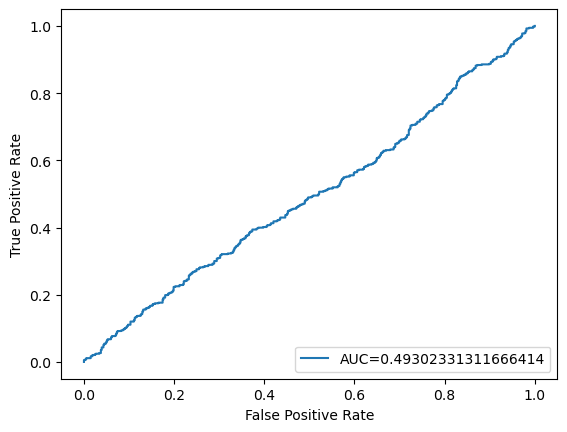

In [98]:
# model evaluation
y_pred_prob = model.predict(X_val)
y_pred_binary = (y_pred_prob > 0.5).astype(int)

test_loss, test_acc = model.evaluate(X_val, y_val, verbose=0)

# precision, recall, and F1-score
precision = precision_score(y_val, y_pred_binary)
recall = recall_score(y_val, y_pred_binary)

print("Accuracy (Validation): {:.4f}".format(test_acc))
print("Loss (Validation): ", history_dict['loss'][-1:])
print("Precision (Validation): {:.4f}".format(precision))
print("Recall (Validation): {:.4f}".format(recall))

# ROC and AUC
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_prob)
auc = metrics.roc_auc_score(y_test, y_pred_prob)

# plot ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)


Baseline model training and validation loss and accuracy graphs: 


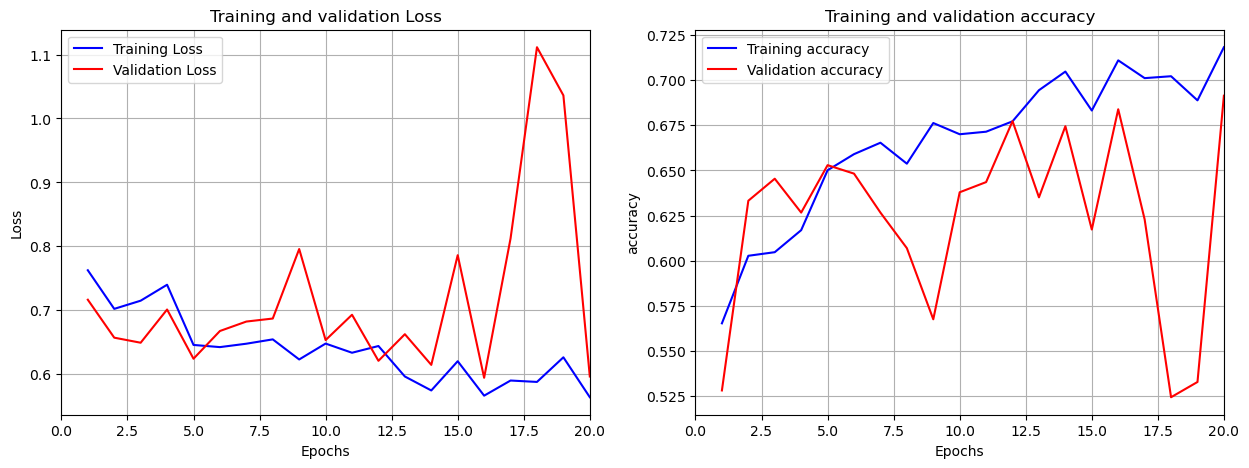

In [127]:
print('Baseline model training and validation loss and accuracy graphs: ')
monitors = ['loss', 'accuracy']
fig, axs = plt.subplots(1, 2, sharex = 'all', figsize = (15, 5))

for ax, monitor in zip(axs.flat, monitors):
    loss, val_loss = history_dict[monitor], history_dict['val_' + monitor]

    if monitor == 'loss':
        monitor = monitor.capitalize()

    epochs = range(1, len(loss) + 1)

    ax.plot(epochs, loss, 'b', label = 'Training ' + monitor)
    ax.plot(epochs, val_loss, 'r', label = 'Validation ' + monitor)
    ax.set_xlim([0, len(loss)])
    ax.title.set_text('Training and validation ' + monitor)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(monitor)
    ax.legend()
    ax.grid()

plt.show()

Baseline model confusion matrix: 


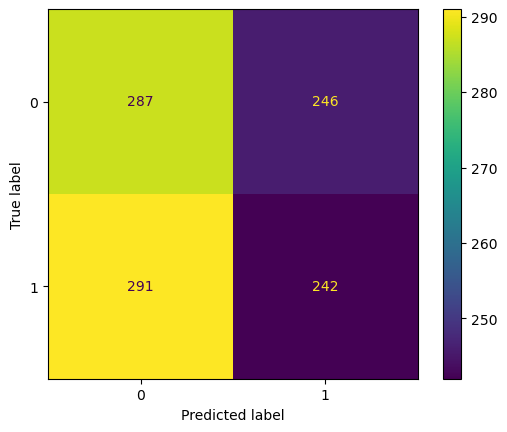

In [126]:
print('Baseline model confusion matrix: ')
# plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, 
                                               (y_pred_binary > 0.5).astype('int32')))
disp.plot()
plt.show()

## CNN-1

## Declaring functions

In [39]:
def build_CNN1(hidden_layers,
              no_of_filters,
              kernel_size,
              pool_size,
              activation,
              input_shape,
               hidden_neurons,
              loss,
              optimizer,
              metrics,
              name):
    
    model = Sequential()

    # feature extraction
    for layer in range(hidden_layers):
        no_of_filters = no_of_filters * 2
        model.add(Conv2D(no_of_filters,
                         kernel_size, 
                         activation = activation, 
                         input_shape = 'default' if layer > 1 else (input_shape)))
        model.add(MaxPooling2D(pool_size = pool_size))

    # classification
    model.add(Flatten())
    model.add(Dense(hidden_neurons,
                    activation = 'relu'))
    model.add(Dense(1, 
                    activation = 'sigmoid'))

    if name is not None:
        model._name = name

    model.compile(optimizer = optimizer, 
                  loss = loss, 
                  metrics = metrics)
    
    return model


In [116]:
def train_CNN(model,
              X,
              y,
              epochs,
              batch_size,
              val_data,
              callbacks = []):
    
    if val_data is None:
        X_train, y_train, X_val, y_val = X, y, None, None
        val_score = None
    else:
        X_train, y_train, X_val, y_val = X, y, val_data[0], val_data[1]
        val_score = model.evaluate(X_val, y_val)
    
    history = model.fit(X_train,
                        y_train,
                        epochs = epochs,
                        batch_size = batch_size,
                        validation_data = val_data,
                        callbacks = callbacks)

    return {'model': model, 
            'val_score': val_score,
            'history': history }

In [41]:
def plot_history(history, monitors = ['loss', 'accuracy']):
    fig, axs = plt.subplots(1, 2, sharex = 'all', figsize = (15, 5))
    
    for ax, monitor in zip(axs.flat, monitors):
        loss, val_loss = history.history[monitor], history.history['val_' + monitor]
        
        if monitor == 'loss':
            monitor = monitor.capitalize()
        
        epochs = range(1, len(loss) + 1)
        
        ax.plot(epochs, loss, 'b', label = 'Training ' + monitor)
        ax.plot(epochs, val_loss, 'r', label = 'Validation ' + monitor)
        ax.set_xlim([0, len(loss)])
        ax.title.set_text('Training and validation ' + monitor)
        ax.set_xlabel('Epochs')
        ax.set_ylabel(monitor)
        ax.legend()
        ax.grid()
    
    _ = plt.show()

## Developing a model that does better than a baseline

In [42]:
lr = 0.001
OPTIMIZER = Adam(learning_rate = lr)
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name = 'precision'), 
           tf.keras.metrics.Recall(name = 'recall'),
           tf.keras.metrics.AUC(name = 'auc')]

In [43]:
iter1_model = build_CNN1(hidden_layers = 3,
                        no_of_filters = 8,
                        kernel_size = (5,5),
                        pool_size = (2,2),
                        activation = 'relu',
                        input_shape = (128,128,3),
                        hidden_neurons = 64,
                        loss = LOSS_FUNC,
                        optimizer = OPTIMIZER,
                        metrics = METRICS,
                        name = "iter1_model")

iter1_model.summary()

Model: "iter1_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)        51264     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       

In [44]:
train_iter1_model = train_CNN(iter1_model,
                              X_train,
                              y_train,
                              epochs = 20,
                              batch_size = 64,
                              val_data = (X_val, y_val),
                              callbacks = None)

Epoch 1/20
134/134 [==============================] - 54s 394ms/step - loss: 0.6702 - accuracy: 0.5925 - precision: 0.5809 - recall: 0.6646 - auc: 0.6266 - val_loss: 0.6348 - val_accuracy: 0.6398 - val_precision: 0.6338 - val_recall: 0.6623 - val_auc: 0.6929
Epoch 2/20
134/134 [==============================] - 55s 409ms/step - loss: 0.6229 - accuracy: 0.6587 - precision: 0.6543 - recall: 0.6726 - auc: 0.7152 - val_loss: 0.6167 - val_accuracy: 0.6632 - val_precision: 0.6157 - val_recall: 0.8687 - val_auc: 0.7437
Epoch 3/20
134/134 [==============================] - 52s 391ms/step - loss: 0.5648 - accuracy: 0.7087 - precision: 0.6983 - recall: 0.7350 - auc: 0.7776 - val_loss: 0.6052 - val_accuracy: 0.6323 - val_precision: 0.7169 - val_recall: 0.4371 - val_auc: 0.7597
Epoch 4/20
134/134 [==============================] - 53s 393ms/step - loss: 0.5284 - accuracy: 0.7274 - precision: 0.7142 - recall: 0.7582 - auc: 0.8067 - val_loss: 0.5776 - val_accuracy: 0.6914 - val_precision: 0.6304 - v

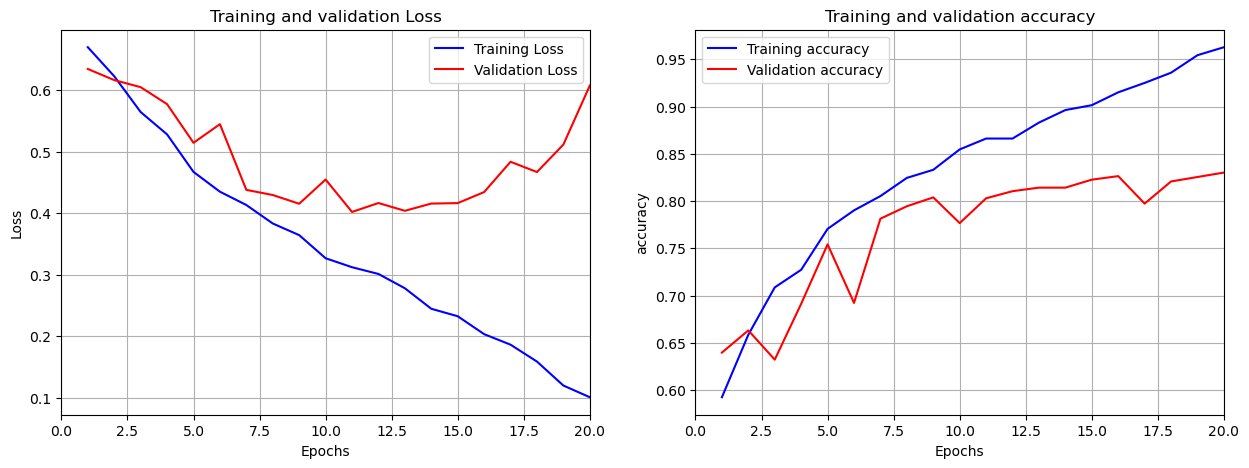

In [45]:
plot_history(train_iter1_model['history'], monitors = ['loss', 'accuracy'])

In [46]:
precision = train_iter1_model['val_score'][2]
recall = train_iter1_model['val_score'][3]
f1_score = 2 * (precision * recall) / (precision + recall)

print('Accuracy: {:.4f}'.format(train_iter1_model['val_score'][1]))
print('Loss: {:.4f}'.format(train_iter1_model['val_score'][0]))
print('Precision: {:.4f}'.format(train_iter1_model['val_score'][2]))
print('Recall: {:.4f}'.format(train_iter1_model['val_score'][3]))
print('F1-score: {:.4f}'.format(f1_score))

Accuracy: 0.8302
Loss: 0.6078
Precision: 0.7821
Recall: 0.9156
F1-score: 0.8436


## Initial regularisation to address overfitting

- increasing kernel size
- increasing no. of hidden units in fully connected dense layer

In [47]:
lr = 0.001
OPTIMIZER = Adam(learning_rate = 0.001)
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name = 'precision'), 
           tf.keras.metrics.Recall(name = 'recall'),
           tf.keras.metrics.AUC(name = 'auc')]

In [48]:
iter2_model = build_CNN1(hidden_layers = 3,
                        no_of_filters = 8,
                        kernel_size = (3,3),
                        pool_size = (2,2),
                        activation = 'relu',
                        input_shape = (128,128,3),
                        hidden_neurons = 32,
                        loss = LOSS_FUNC,
                        optimizer = OPTIMIZER,
                        metrics = METRICS,
                        name = "iter2_model")

iter2_model.summary()

Model: "iter2_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)       

In [49]:
train_iter2_model = train_CNN(iter2_model,
                              X_train,
                              y_train,
                              epochs = 20,
                              batch_size = 64,
                              val_data = (X_val, y_val),
                              callbacks = None)

Epoch 1/20
134/134 [==============================] - 37s 266ms/step - loss: 0.6481 - accuracy: 0.6170 - precision: 0.6094 - recall: 0.6520 - auc: 0.6703 - val_loss: 0.6041 - val_accuracy: 0.6595 - val_precision: 0.6451 - val_recall: 0.7092 - val_auc: 0.7322
Epoch 2/20
134/134 [==============================] - 35s 261ms/step - loss: 0.5637 - accuracy: 0.7098 - precision: 0.7070 - recall: 0.7165 - auc: 0.7813 - val_loss: 0.5382 - val_accuracy: 0.7167 - val_precision: 0.6948 - val_recall: 0.7730 - val_auc: 0.8038
Epoch 3/20
134/134 [==============================] - 35s 261ms/step - loss: 0.5062 - accuracy: 0.7478 - precision: 0.7395 - recall: 0.7650 - auc: 0.8297 - val_loss: 0.5088 - val_accuracy: 0.7505 - val_precision: 0.6894 - val_recall: 0.9118 - val_auc: 0.8568
Epoch 4/20
134/134 [==============================] - 35s 260ms/step - loss: 0.4510 - accuracy: 0.7871 - precision: 0.7753 - recall: 0.8084 - auc: 0.8678 - val_loss: 0.5483 - val_accuracy: 0.7392 - val_precision: 0.6698 - v

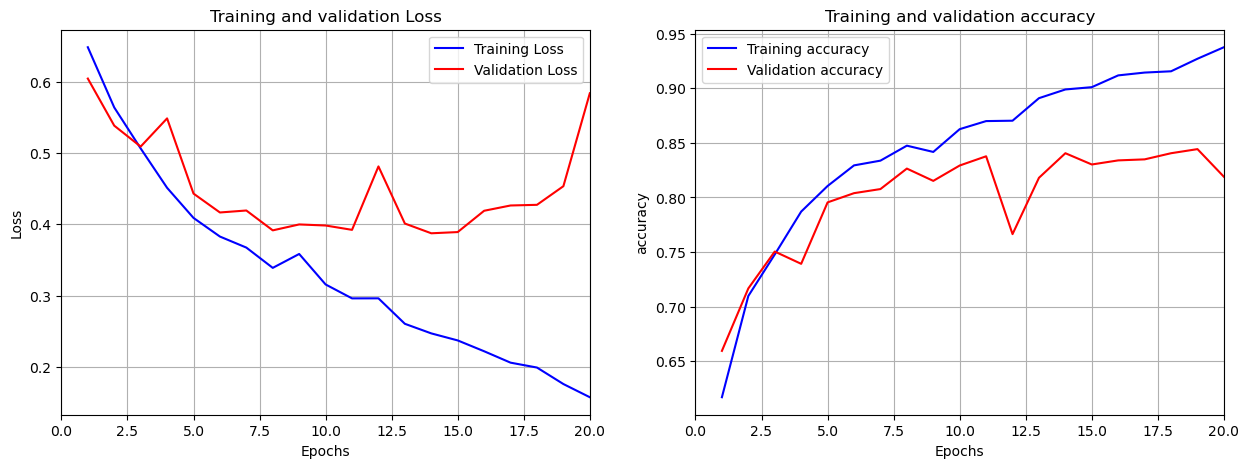

In [50]:
plot_history(train_iter2_model['history'], monitors = ['loss', 'accuracy'])

In [51]:
precision = train_iter2_model['val_score'][2]
recall = train_iter2_model['val_score'][3]
f1_score = 2 * (precision * recall) / (precision + recall)

print('iter2_model')
print('Accuracy: {:.4f}'.format(train_iter2_model['val_score'][1]))
print('Loss: {:.4f}'.format(train_iter2_model['val_score'][0]))
print('Precision: {:.4f}'.format(train_iter2_model['val_score'][2]))
print('Recall: {:.4f}'.format(train_iter2_model['val_score'][3]))
print('F1-score: {:.4f}'.format(f1_score))

Accuracy: 0.8189
Loss: 0.5835
Precision: 0.7568
Recall: 0.9400
F1-score: 0.8385


## Regularising model

Function for regularised model

In [52]:
from keras.layers import Dropout
from keras import regularizers

In [53]:
def build_reg_CNN(hidden_layers = 3,
                  no_of_filters = 8,
                  kernel_size = (3,3),
                  pool_size = (2,2),
                  activation = 'relu',
                  input_shape = (128,128,3),
                  hidden_neurons = 32,
                  loss = 'binary_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'],
                  name = None,
                  dropout = None,
                  weight_regs = None):
    
    model = Sequential()

    # feature extraction
    for layer in range(hidden_layers):
        no_of_filters = no_of_filters * 2
        model.add(Conv2D(no_of_filters,
                         kernel_size, 
                         activation = activation, 
                         input_shape = 'default' if layer > 1 else (input_shape)))
        model.add(MaxPooling2D(pool_size = pool_size))

    # classification
    model.add(Flatten())
    model.add(Dense(hidden_neurons,
                    activation = 'relu',
                    kernel_regularizer = weight_regs))
    if dropout is not None:
        model.add(Dropout(dropout))
    model.add(Dense(1, 
                    activation = 'sigmoid'))

    if name is not None:
        model._name = name

    model.compile(optimizer = optimizer, 
                  loss = loss, 
                  metrics = metrics)
    
    return model


### Add dropouts

In [54]:
lr = 0.001
OPTIMIZER = Adam(learning_rate = lr)
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name = 'precision'), 
           tf.keras.metrics.Recall(name = 'recall'),
           tf.keras.metrics.AUC(name = 'auc')]

In [55]:
lr = 0.001
OPTIMIZER = Adam(learning_rate = lr)
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name = 'precision'), 
           tf.keras.metrics.Recall(name = 'recall'),
           tf.keras.metrics.AUC(name = 'auc')]

DROPOUT = 0.1

dpout_model = build_reg_CNN(hidden_layers = 3,
                          no_of_filters = 8,
                          kernel_size = (3,3),
                          pool_size = (2,2),
                          activation = 'relu',
                          input_shape = (128,128,3),
                          hidden_neurons = 32,
                          loss = LOSS_FUNC,
                          optimizer = OPTIMIZER,
                          metrics = METRICS,
                          name = "dpout_model",
                          dropout = DROPOUT,
                          weight_regs = None)

In [56]:
train_dpout_model = train_CNN(dpout_model,
                            X_train, 
                            y_train,
                            epochs = 20,
                            batch_size = 64,
                            val_data = (X_val, y_val),
                            callbacks = None)

Epoch 1/20
134/134 [==============================] - 39s 285ms/step - loss: 0.6622 - accuracy: 0.6042 - precision: 0.5976 - recall: 0.6381 - auc: 0.6464 - val_loss: 0.6458 - val_accuracy: 0.6351 - val_precision: 0.6208 - val_recall: 0.6942 - val_auc: 0.6800
Epoch 2/20
134/134 [==============================] - 37s 277ms/step - loss: 0.6201 - accuracy: 0.6554 - precision: 0.6582 - recall: 0.6463 - auc: 0.7172 - val_loss: 0.6147 - val_accuracy: 0.6595 - val_precision: 0.6358 - val_recall: 0.7467 - val_auc: 0.7217
Epoch 3/20
134/134 [==============================] - 38s 280ms/step - loss: 0.5882 - accuracy: 0.6855 - precision: 0.6794 - recall: 0.7024 - auc: 0.7522 - val_loss: 0.5780 - val_accuracy: 0.6867 - val_precision: 0.6311 - val_recall: 0.8987 - val_auc: 0.7966
Epoch 4/20
134/134 [==============================] - 41s 302ms/step - loss: 0.5235 - accuracy: 0.7378 - precision: 0.7245 - recall: 0.7674 - auc: 0.8172 - val_loss: 0.5172 - val_accuracy: 0.7439 - val_precision: 0.7416 - v

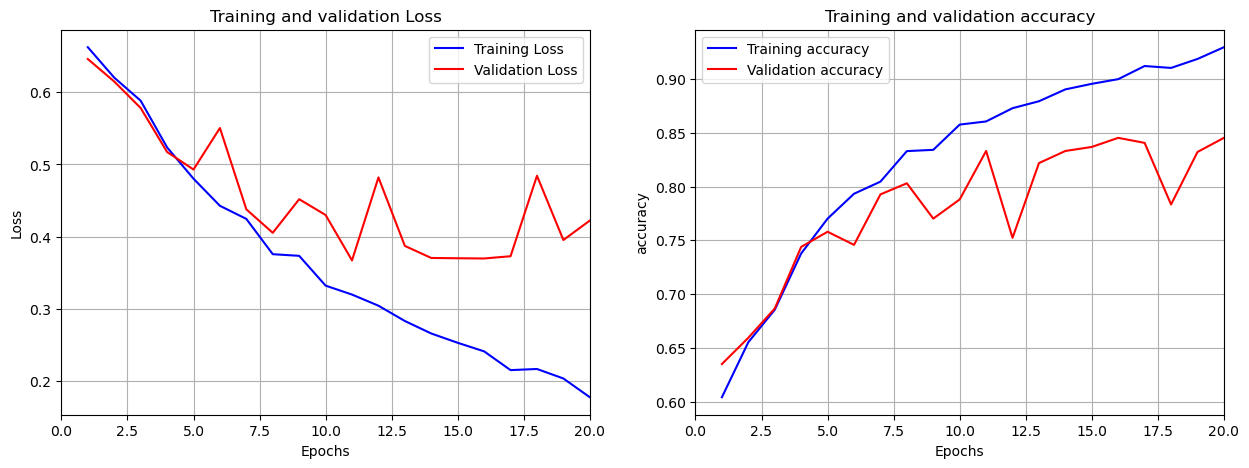

In [57]:
plot_history(train_dpout_model['history'], monitors = ['loss', 'accuracy'])

In [58]:
precision = train_dpout_model['val_score'][2]
recall = train_dpout_model['val_score'][3]
f1_score = 2 * (precision * recall) / (precision + recall)

print('dpout_model')
print('Accuracy: {:.4f}'.format(train_dpout_model['val_score'][1]))
print('Loss: {:.4f}'.format(train_dpout_model['val_score'][0]))
print('Precision: {:.4f}'.format(train_dpout_model['val_score'][2]))
print('Recall: {:.4f}'.format(train_dpout_model['val_score'][3]))
print('F1-score: {:.4f}'.format(f1_score))

Accuracy: 0.8452
Loss: 0.4223
Precision: 0.8007
Recall: 0.9193
F1-score: 0.8559


### L1 Regularisation

In [59]:
lr = 0.001
OPTIMIZER = Adam(learning_rate = lr)
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name = 'precision'), 
           tf.keras.metrics.Recall(name = 'recall'),
           tf.keras.metrics.AUC(name = 'auc')]
DROPOUT = 0.1

WEIGHT_REGS = regularizers.l1(0.001)

regL1_model = build_reg_CNN(hidden_layers = 3,
                          no_of_filters = 8,
                          kernel_size = (3,3),
                          pool_size = (2,2),
                          activation = 'relu',
                          input_shape = (128,128,3),
                          hidden_neurons = 32,
                          loss = LOSS_FUNC,
                          optimizer = OPTIMIZER,
                          metrics = METRICS,
                          name = "regL1_model",
                          dropout = DROPOUT,
                          weight_regs = WEIGHT_REGS)

In [60]:
train_regL1_model = train_CNN(regL1_model,
                            X_train, 
                            y_train,
                            epochs = 20,
                            batch_size = 64,
                            val_data = (X_val, y_val),
                            callbacks = None)

Epoch 1/20
134/134 [==============================] - 39s 279ms/step - loss: 1.0737 - accuracy: 0.5597 - precision: 0.5499 - recall: 0.6576 - auc: 0.5905 - val_loss: 0.7359 - val_accuracy: 0.6032 - val_precision: 0.5865 - val_recall: 0.6998 - val_auc: 0.6491
Epoch 2/20
134/134 [==============================] - 37s 275ms/step - loss: 0.7285 - accuracy: 0.6052 - precision: 0.6178 - recall: 0.5516 - auc: 0.6547 - val_loss: 0.7394 - val_accuracy: 0.6013 - val_precision: 0.5931 - val_recall: 0.6454 - val_auc: 0.6457
Epoch 3/20
134/134 [==============================] - 37s 272ms/step - loss: 0.7197 - accuracy: 0.6184 - precision: 0.6194 - recall: 0.6142 - auc: 0.6665 - val_loss: 0.7248 - val_accuracy: 0.6013 - val_precision: 0.6169 - val_recall: 0.5347 - val_auc: 0.6606
Epoch 4/20
134/134 [==============================] - 36s 271ms/step - loss: 0.7095 - accuracy: 0.6295 - precision: 0.6276 - recall: 0.6367 - auc: 0.6791 - val_loss: 0.7091 - val_accuracy: 0.6163 - val_precision: 0.6131 - v

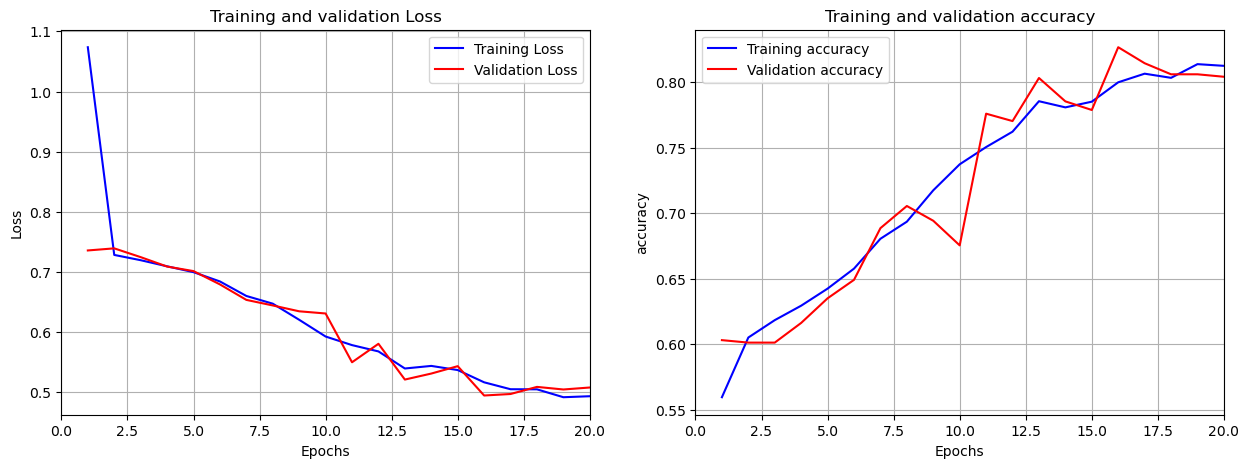

In [61]:
plot_history(train_regL1_model['history'], monitors = ['loss', 'accuracy'])

In [62]:
precision = train_regL1_model['val_score'][2]
recall = train_regL1_model['val_score'][3]
f1_score = 2 * (precision * recall) / (precision + recall)

print('regL1_model')
print('Accuracy: {:.4f}'.format(train_regL1_model['val_score'][1]))
print('Loss: {:.4f}'.format(train_regL1_model['val_score'][0]))
print('Precision: {:.4f}'.format(train_regL1_model['val_score'][2]))
print('Recall: {:.4f}'.format(train_regL1_model['val_score'][3]))
print('F1-score: {:.4f}'.format(f1_score))

Accuracy: 0.8039
Loss: 0.5081
Precision: 0.7389
Recall: 0.9400
F1-score: 0.8274


### L2 Regularisation

In [63]:
lr = 0.001
OPTIMIZER = Adam(learning_rate = lr)
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name = 'precision'), 
           tf.keras.metrics.Recall(name = 'recall'),
           tf.keras.metrics.AUC(name = 'auc')]
DROPOUT = 0.1

WEIGHT_REGS = regularizers.l2(0.001)

regL2_model = build_reg_CNN(hidden_layers = 3,
                          no_of_filters = 8,
                          kernel_size = (3,3),
                          pool_size = (2,2),
                          activation = 'relu',
                          input_shape = (128,128,3),
                          hidden_neurons = 32,
                          loss = LOSS_FUNC,
                          optimizer = OPTIMIZER,
                          metrics = METRICS,
                          name = "regL2_model",
                          dropout = DROPOUT,
                          weight_regs = WEIGHT_REGS)

In [64]:
train_regL2_model = train_CNN(regL2_model,
                            X_train, 
                            y_train,
                            epochs = 20,
                            batch_size = 64,
                            val_data = (X_val, y_val),
                            callbacks = None)

Epoch 1/20
134/134 [==============================] - 46s 333ms/step - loss: 0.6838 - accuracy: 0.5848 - precision: 0.5783 - recall: 0.6262 - auc: 0.6201 - val_loss: 0.6633 - val_accuracy: 0.6013 - val_precision: 0.6139 - val_recall: 0.5460 - val_auc: 0.6604
Epoch 2/20
134/134 [==============================] - 43s 319ms/step - loss: 0.6513 - accuracy: 0.6244 - precision: 0.6266 - recall: 0.6159 - auc: 0.6818 - val_loss: 0.6611 - val_accuracy: 0.6201 - val_precision: 0.5964 - val_recall: 0.7430 - val_auc: 0.6697
Epoch 3/20
134/134 [==============================] - 44s 328ms/step - loss: 0.6315 - accuracy: 0.6606 - precision: 0.6546 - recall: 0.6803 - auc: 0.7142 - val_loss: 0.6506 - val_accuracy: 0.6201 - val_precision: 0.7177 - val_recall: 0.3959 - val_auc: 0.7204
Epoch 4/20
134/134 [==============================] - 44s 330ms/step - loss: 0.5945 - accuracy: 0.7032 - precision: 0.6936 - recall: 0.7280 - auc: 0.7664 - val_loss: 0.5814 - val_accuracy: 0.6904 - val_precision: 0.6667 - v

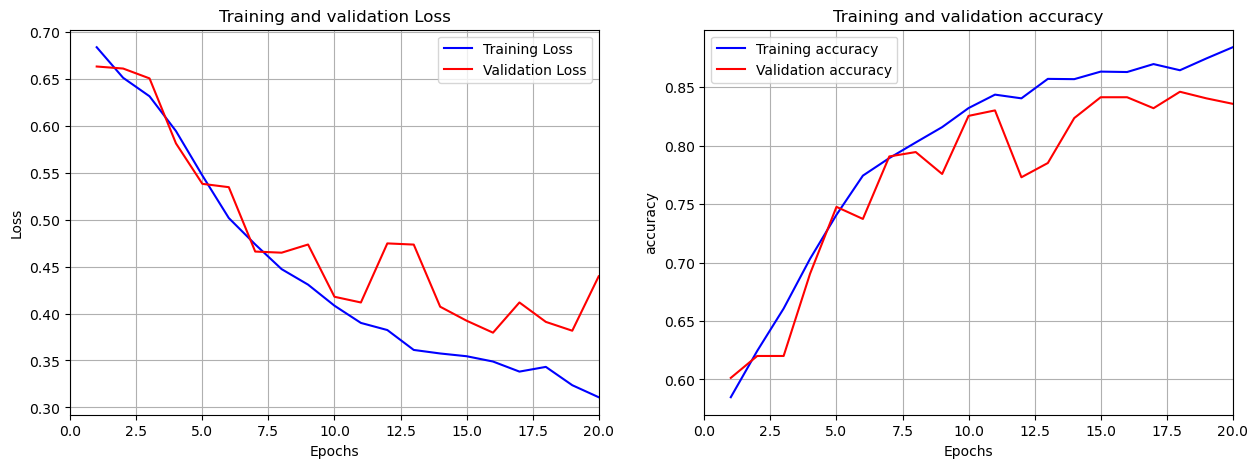

In [65]:
plot_history(train_regL2_model['history'], monitors = ['loss', 'accuracy'])

In [66]:
precision = train_regL2_model['val_score'][2]
recall = train_regL2_model['val_score'][3]
f1_score = 2 * (precision * recall) / (precision + recall)

print('regL2_model')
print('Accuracy: {:.4f}'.format(train_regL2_model['val_score'][1]))
print('Loss: {:.4f}'.format(train_regL2_model['val_score'][0]))
print('Precision: {:.4f}'.format(train_regL2_model['val_score'][2]))
print('Recall: {:.4f}'.format(train_regL2_model['val_score'][3]))
print('F1-score: {:.4f}'.format(f1_score))

Validation
Accuracy: 0.8358
Loss: 0.4397
Precision: 0.7887
Recall: 0.9174
F1-score: 0.8482


## Hyperparameters tuning

In [67]:
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [68]:
model = KerasClassifier(build_fn = build_reg_CNN, verbose = 0)
param_dist = {
    'pool_size': [(2,2), (4,4)],
    'dropout': [0.1, 0.3],
}

random_search = RandomizedSearchCV(estimator = model, 
                                   param_distributions = param_dist, 
                                   n_iter = 5, 
                                   scoring = 'accuracy', 
                                   cv = 3, 
                                   verbose = 1,
                                   error_score='raise')

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/var/folders/f0/t9dz214d4_3d_q_bqc2tsfj40000gn/T/ipykernel_56136/150422605.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = build_reg_CNN, verbose = 0)
/Users/rajasuvedhavivekanandan/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


89/89 [==============================] - 2s 17ms/step


RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fd4e62abb20>,
                   n_iter=5,
                   param_distributions={'dropout': [0.1, 0.3],
                                        'pool_size': [(2, 2), (4, 4)]},
                   scoring='accuracy', verbose=1)

In [69]:
print("The best parameters:\n", random_search.best_params_)

The best parameters:
 {'pool_size': (4, 4), 'dropout': 0.1}


## Finalised CNN-1 with optimised hyperparameters

In [70]:
# optimised hyperparameters
POOL_SIZE = (4,4)
DROPOUT = 0.1

# other parameters
WEIGHT_REGS = regularizers.l2(0.001)
OPTIMIZER = Adam(learning_rate = 0.001)
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name = 'precision'), 
           tf.keras.metrics.Recall(name = 'recall'),
           tf.keras.metrics.AUC(name = 'auc')]

In [71]:
cnn1_model = build_reg_CNN(hidden_layers = 3,
                          no_of_filters = 8,
                          kernel_size = (3,3),
                          pool_size = POOL_SIZE,
                          activation = 'relu',
                          input_shape = (128,128,3),
                          hidden_neurons = 32,
                          loss = LOSS_FUNC,
                          optimizer = OPTIMIZER,
                          metrics = METRICS,
                          name = "cnn1_model",
                          dropout = DROPOUT,
                          weight_regs = WEIGHT_REGS)

In [72]:
train_cnn1_model = train_CNN(cnn1_model,
                            X_train, 
                            y_train,
                            epochs = 20,
                            batch_size = 64,
                            val_data = (X_val, y_val),
                            callbacks = None)

Epoch 1/20
134/134 [==============================] - 21s 145ms/step - loss: 0.7001 - accuracy: 0.5716 - precision: 0.5603 - recall: 0.6656 - auc: 0.6058 - val_loss: 0.6646 - val_accuracy: 0.6257 - val_precision: 0.6159 - val_recall: 0.6679 - val_auc: 0.6722
Epoch 2/20
134/134 [==============================] - 20s 148ms/step - loss: 0.6522 - accuracy: 0.6286 - precision: 0.6345 - recall: 0.6067 - auc: 0.6842 - val_loss: 0.6621 - val_accuracy: 0.6351 - val_precision: 0.5893 - val_recall: 0.8912 - val_auc: 0.7002
Epoch 3/20
134/134 [==============================] - 20s 150ms/step - loss: 0.6230 - accuracy: 0.6671 - precision: 0.6694 - recall: 0.6602 - auc: 0.7253 - val_loss: 0.6349 - val_accuracy: 0.6323 - val_precision: 0.7660 - val_recall: 0.3809 - val_auc: 0.7634
Epoch 4/20
134/134 [==============================] - 20s 152ms/step - loss: 0.5887 - accuracy: 0.6956 - precision: 0.6899 - recall: 0.7106 - auc: 0.7638 - val_loss: 0.5660 - val_accuracy: 0.7176 - val_precision: 0.7071 - v

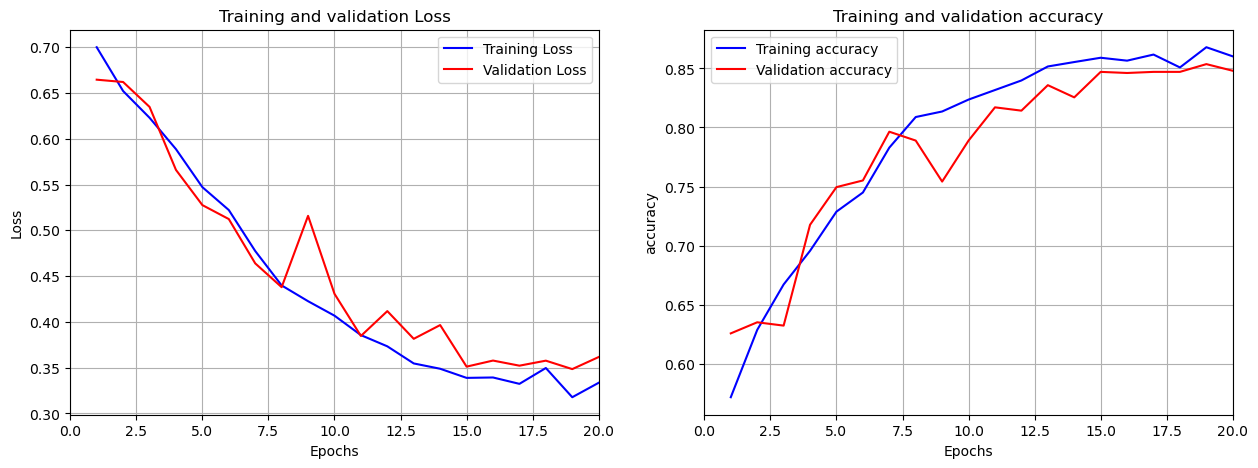

In [73]:
plot_history(train_cnn1_model['history'], monitors = ['loss', 'accuracy'])

In [74]:
precision = train_cnn1_model['val_score'][2]
recall = train_cnn1_model['val_score'][3]
f1_score = 2 * (precision * recall) / (precision + recall)

print('cnn1_model')
print('Accuracy: {:.4f}'.format(train_cnn1_model['val_score'][1]))
print('Loss: {:.4f}'.format(train_cnn1_model['val_score'][0]))
print('Precision: {:.4f}'.format(train_cnn1_model['val_score'][2]))
print('Recall: {:.4f}'.format(train_cnn1_model['val_score'][3]))
print('F1-score: {:.4f}'.format(f1_score))

Validation
Accuracy: 0.8480
Loss: 0.3616
Precision: 0.7968
Recall: 0.9343
F1-score: 0.8601


## CNN-2, second model

In [75]:
from tensorflow.keras.layers import SeparableConv2D

In [76]:
def build_CNN2(hidden_layers,
              no_of_filters,
              kernel_size,
              pool_size,
              activation,
              input_shape,
              hidden_neurons,
              loss,
              optimizer,
              metrics,
              name,
              dropout,
              weight_regs):
    
    model = Sequential()

    # feature extraction 
    for layer in range(hidden_layers):
        no_of_filters = no_of_filters * 2
        model.add(SeparableConv2D(no_of_filters,
                                 kernel_size, 
                                 activation = activation, 
                                 input_shape = 'default' if layer > 1 else (input_shape)))
        model.add(MaxPooling2D(pool_size = pool_size))

    # classification
    model.add(Flatten())
    model.add(Dense(hidden_neurons,
                    activation = 'relu',
                    kernel_regularizer = weight_regs))
    if ~np.isnan(dropout):
            model.add(Dropout(dropout))
    model.add(Dense(1, 
                    activation = 'sigmoid'))

    if name is not None:
        model._name = name

    model.compile(optimizer = optimizer, 
                  loss = loss, 
                  metrics = metrics)
    
    return model

In [77]:
# optimised hyperparameters
POOL_SIZE = (4,4)
DROPOUT = 0.1

# other parameters
WEIGHT_REGS = regularizers.l2(0.001)
OPTIMIZER = Adam(learning_rate = 0.001)
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name = 'precision'), 
           tf.keras.metrics.Recall(name = 'recall'),
           tf.keras.metrics.AUC(name = 'auc')]

In [78]:
cnn2_model = build_CNN2(hidden_layers = 3,
                      no_of_filters = 8,
                      kernel_size = (3,3),
                      pool_size = (2,2),
                      activation = 'relu',
                      input_shape = (128,128,3),
                      hidden_neurons = 32,
                      loss = LOSS_FUNC,
                      optimizer = OPTIMIZER,
                      metrics = METRICS,
                      name = "cnn2_model",
                      dropout = DROPOUT,
                      weight_regs = WEIGHT_REGS)
cnn2_model.summary()

Model: "cnn2_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d (Separable  (None, 126, 126, 16)     91        
 Conv2D)                                                         
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 63, 63, 16)       0         
 g2D)                                                            
                                                                 
 separable_conv2d_1 (Separab  (None, 61, 61, 32)       688       
 leConv2D)                                                       
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                            
                                                                 
 separable_conv2d_2 (Separab  (None, 28, 28, 64)       2

In [79]:
train_cnn2_model = train_CNN(cnn2_model,
                            X_train, 
                            y_train,
                            epochs = 20,
                            batch_size = 64,
                            val_data = (X_val, y_val),
                            callbacks = None)

Epoch 1/20
134/134 [==============================] - 34s 239ms/step - loss: 0.6962 - accuracy: 0.5237 - precision: 0.5135 - recall: 0.8977 - auc: 0.5302 - val_loss: 0.6878 - val_accuracy: 0.5141 - val_precision: 0.5072 - val_recall: 0.9944 - val_auc: 0.6397
Epoch 2/20
134/134 [==============================] - 31s 234ms/step - loss: 0.6770 - accuracy: 0.5940 - precision: 0.5768 - recall: 0.7059 - auc: 0.6361 - val_loss: 0.6872 - val_accuracy: 0.5572 - val_precision: 0.5327 - val_recall: 0.9325 - val_auc: 0.6483
Epoch 3/20
134/134 [==============================] - 32s 239ms/step - loss: 0.6707 - accuracy: 0.6119 - precision: 0.6135 - recall: 0.6046 - auc: 0.6443 - val_loss: 0.6709 - val_accuracy: 0.5994 - val_precision: 0.5833 - val_recall: 0.6961 - val_auc: 0.6525
Epoch 4/20
134/134 [==============================] - 32s 237ms/step - loss: 0.6626 - accuracy: 0.6291 - precision: 0.6270 - recall: 0.6372 - auc: 0.6691 - val_loss: 0.6677 - val_accuracy: 0.5985 - val_precision: 0.5862 - v

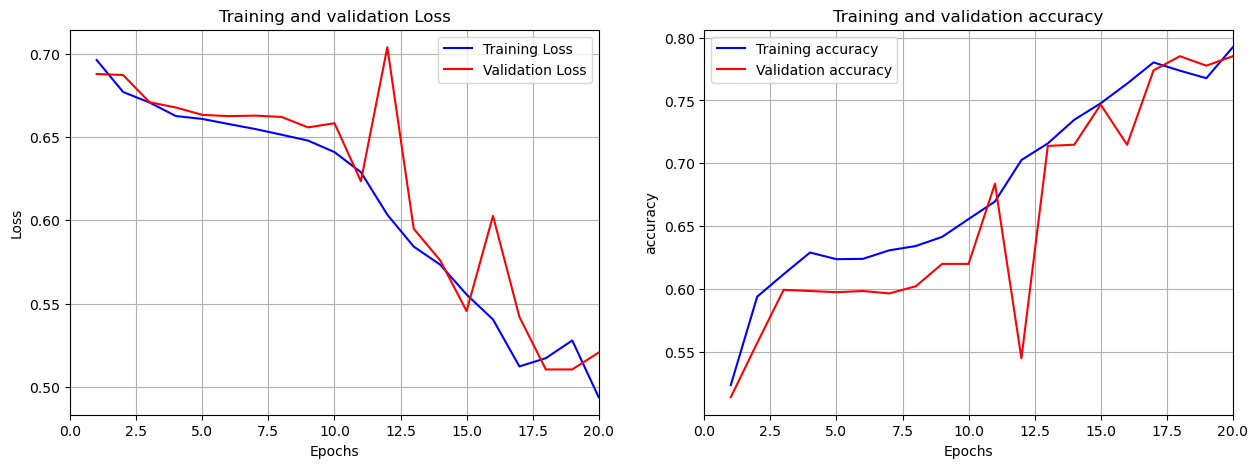

In [80]:
plot_history(train_cnn2_model['history'], monitors = ['loss', 'accuracy'])

In [81]:
precision = train_cnn2_model['val_score'][2]
recall = train_cnn2_model['val_score'][3]
f1_score = 2 * (precision * recall) / (precision + recall)

print('cnn2_model')
print('Accuracy: {:.4f}'.format(train_cnn2_model['val_score'][1]))
print('Loss: {:.4f}'.format(train_cnn2_model['val_score'][0]))
print('Precision: {:.4f}'.format(train_cnn2_model['val_score'][2]))
print('Recall: {:.4f}'.format(train_cnn2_model['val_score'][3]))
print('F1-score: {:.4f}'.format(f1_score))

cnn2_model
Accuracy: 0.7852
Loss: 0.5207
Precision: 0.7360
Recall: 0.8893
F1-score: 0.8054


## CNN-1 with VGG16 base model

In [82]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

In [84]:
def build_pretrain(activation,
                  input_shape,
                  hidden_neurons,
                  loss,
                  optimizer,
                  metrics,
                  name,
                  dropout,
                  weight_regs):
    
    model = Sequential()
    
    # Feature extraction using VGG16 as the base model
    conv_base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = input_shape)
    conv_base.trainable = False
    model.add(conv_base)
    
    # classification
    model.add(Flatten())
    model.add(Dense(hidden_neurons,
                    activation = 'relu',
                    kernel_regularizer = weight_regs))
    if dropout is not None:
        model.add(Dropout(dropout))
    model.add(Dense(1, 
                    activation = 'sigmoid'))

    if name is not None:
        model._name = name

    model.compile(optimizer = optimizer, 
                  loss = loss, 
                  metrics = metrics)
    
    return model

In [85]:
# optimised hyperparameters
DROPOUT = 0.1
WEIGHT_REGS = regularizers.l2(0.001)

OPTIMIZER = Adam(learning_rate = 0.001)
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name = 'precision'), 
           tf.keras.metrics.Recall(name = 'recall'),
           tf.keras.metrics.AUC(name = 'auc')]

vgg16_model = build_pretrain(activation = 'relu',
                          input_shape = (128,128,3),
                          hidden_neurons = 32,
                          loss = LOSS_FUNC,
                          optimizer = OPTIMIZER,
                          metrics = METRICS,
                          name = "vgg16_model",
                          dropout = DROPOUT,
                          weight_regs = WEIGHT_REGS)

vgg16_model.summary()

Model: "vgg16_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_21 (Flatten)        (None, 8192)              0         
                                                                 
 dense_41 (Dense)            (None, 32)                262176    
                                                                 
 dropout_18 (Dropout)        (None, 32)                0         
                                                                 
 dense_42 (Dense)            (None, 1)                 33        
                                                                 
Total params: 14,976,897
Trainable params: 262,209
Non-trainable params: 14,714,688
_________________________________________________________________


In [86]:
print('This is the number of trainable weights '
          'after freezing the conv base:', len(vgg16_model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [99]:
train_vgg16_model = train_CNN(vgg16_model,
                              X_train,
                              y_train,
                              epochs = 10,
                              batch_size = 64,
                              val_data = (X_val, y_val),
                              callbacks = None)

Epoch 1/10
134/134 [==============================] - 279s 2s/step - loss: 0.6146 - accuracy: 0.6864 - precision: 0.6850 - recall: 0.6904 - auc: 0.7471 - val_loss: 0.5987 - val_accuracy: 0.7092 - val_precision: 0.7046 - val_recall: 0.7205 - val_auc: 0.7700
Epoch 2/10
134/134 [==============================] - 277s 2s/step - loss: 0.5851 - accuracy: 0.7081 - precision: 0.7062 - recall: 0.7129 - auc: 0.7780 - val_loss: 0.6020 - val_accuracy: 0.7036 - val_precision: 0.6579 - val_recall: 0.8480 - val_auc: 0.7792
Epoch 3/10
134/134 [==============================] - 308s 2s/step - loss: 0.5747 - accuracy: 0.7159 - precision: 0.7072 - recall: 0.7369 - auc: 0.7868 - val_loss: 0.5764 - val_accuracy: 0.7008 - val_precision: 0.7193 - val_recall: 0.6585 - val_auc: 0.7901
Epoch 4/10
134/134 [==============================] - 303s 2s/step - loss: 0.5546 - accuracy: 0.7301 - precision: 0.7212 - recall: 0.7500 - auc: 0.8064 - val_loss: 0.5740 - val_accuracy: 0.7242 - val_precision: 0.6975 - val_recal

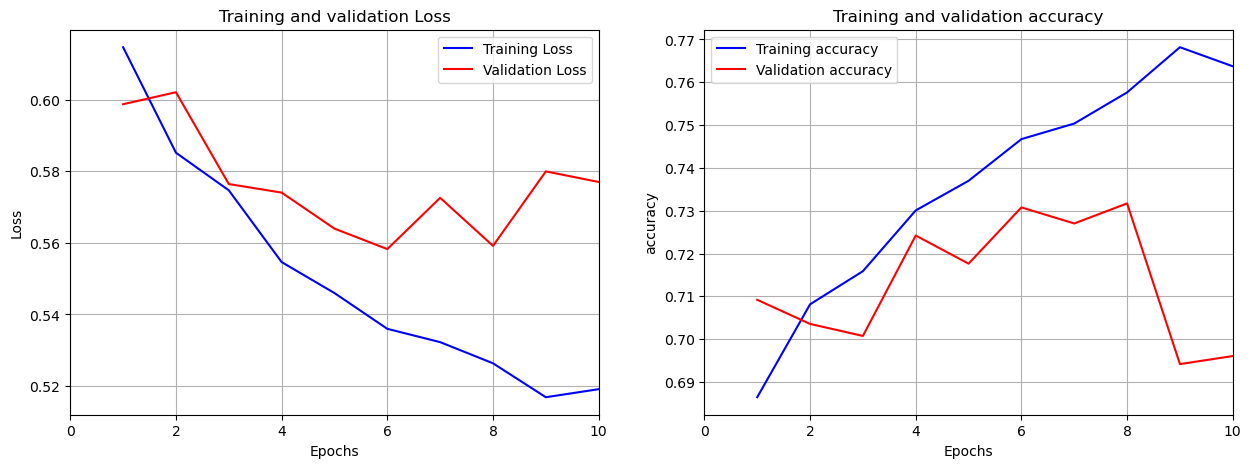

In [100]:
plot_history(train_vgg16_model['history'], monitors = ['loss', 'accuracy'])

In [101]:
precision = train_vgg16_model['val_score'][2]
recall = train_vgg16_model['val_score'][3]
f1_score = 2 * (precision * recall) / (precision + recall)

print('vgg16_model')
print('Accuracy: {:.4f}'.format(train_vgg16_model['val_score'][1]))
print('Loss: {:.4f}'.format(train_vgg16_model['val_score'][0]))
print('Precision: {:.4f}'.format(train_vgg16_model['val_score'][2]))
print('Recall: {:.4f}'.format(train_vgg16_model['val_score'][3]))
print('F1-score: {:.4f}'.format(f1_score))

vgg16_model
Accuracy: 0.6961
Loss: 0.5770
Precision: 0.7555
Recall: 0.5797
F1-score: 0.6561


## Test every model on unseen test data

### Training on all training data

In [111]:
full_data = (np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))

In [118]:
# CNN-1 model
train_cnn1_model = train_CNN(cnn1_model,
                            full_data[0], 
                            full_data[1],
                            epochs = 20,
                            batch_size = 64,
                            val_data = None,
                            callbacks = None)

Epoch 1/20
150/150 [==============================] - 23s 153ms/step - loss: 0.1011 - accuracy: 0.9695 - precision: 0.9655 - recall: 0.9737 - auc: 0.9947
Epoch 2/20
150/150 [==============================] - 23s 151ms/step - loss: 0.1141 - accuracy: 0.9634 - precision: 0.9597 - recall: 0.9675 - auc: 0.9931
Epoch 3/20
150/150 [==============================] - 23s 151ms/step - loss: 0.1005 - accuracy: 0.9698 - precision: 0.9655 - recall: 0.9744 - auc: 0.9948
Epoch 4/20
150/150 [==============================] - 23s 150ms/step - loss: 0.0788 - accuracy: 0.9802 - precision: 0.9776 - recall: 0.9829 - auc: 0.9969
Epoch 5/20
150/150 [==============================] - 23s 152ms/step - loss: 0.0808 - accuracy: 0.9787 - precision: 0.9767 - recall: 0.9808 - auc: 0.9966
Epoch 6/20
150/150 [==============================] - 22s 147ms/step - loss: 0.0816 - accuracy: 0.9782 - precision: 0.9749 - recall: 0.9817 - auc: 0.9968
Epoch 7/20
150/150 [==============================] - 23s 152ms/step - loss:

In [119]:
# CNN-2 model
train_cnn2_model = train_CNN(cnn2_model,
                            full_data[0], 
                            full_data[1],
                            epochs = 20,
                            batch_size = 64,
                            val_data = None,
                            callbacks = None)

Epoch 1/20
150/150 [==============================] - 38s 253ms/step - loss: 0.4898 - accuracy: 0.7917 - precision: 0.8006 - recall: 0.7769 - auc: 0.8733
Epoch 2/20
150/150 [==============================] - 37s 244ms/step - loss: 0.4918 - accuracy: 0.7922 - precision: 0.8012 - recall: 0.7772 - auc: 0.8723
Epoch 3/20
150/150 [==============================] - 35s 230ms/step - loss: 0.4687 - accuracy: 0.8068 - precision: 0.8152 - recall: 0.7934 - auc: 0.8870
Epoch 4/20
150/150 [==============================] - 35s 231ms/step - loss: 0.4693 - accuracy: 0.8054 - precision: 0.8153 - recall: 0.7897 - auc: 0.8876
Epoch 5/20
150/150 [==============================] - 35s 232ms/step - loss: 0.4504 - accuracy: 0.8189 - precision: 0.8283 - recall: 0.8047 - auc: 0.8979
Epoch 6/20
150/150 [==============================] - 35s 231ms/step - loss: 0.4566 - accuracy: 0.8134 - precision: 0.8271 - recall: 0.7926 - auc: 0.8935
Epoch 7/20
150/150 [==============================] - 35s 231ms/step - loss:

In [128]:
# VGG16 model
train_vgg16_model = train_CNN(vgg16_model,
                            full_data[0], 
                            full_data[1],
                            epochs = 10,
                            batch_size = 64,
                            val_data = None,
                            callbacks = None)

Epoch 1/10
150/150 [==============================] - 279s 2s/step - loss: 0.5057 - accuracy: 0.7670 - precision: 0.7482 - recall: 0.8051 - auc: 0.8485
Epoch 2/10
150/150 [==============================] - 280s 2s/step - loss: 0.5134 - accuracy: 0.7618 - precision: 0.7438 - recall: 0.7988 - auc: 0.8431
Epoch 3/10
150/150 [==============================] - 304s 2s/step - loss: 0.5030 - accuracy: 0.7727 - precision: 0.7535 - recall: 0.8105 - auc: 0.8525
Epoch 4/10
150/150 [==============================] - 328s 2s/step - loss: 0.5002 - accuracy: 0.7695 - precision: 0.7513 - recall: 0.8059 - auc: 0.8543
Epoch 5/10
150/150 [==============================] - 358s 2s/step - loss: 0.4920 - accuracy: 0.7778 - precision: 0.7549 - recall: 0.8226 - auc: 0.8606
Epoch 6/10
150/150 [==============================] - 430s 3s/step - loss: 0.4923 - accuracy: 0.7816 - precision: 0.7588 - recall: 0.8257 - auc: 0.8602
Epoch 7/10
150/150 [==============================] - 460s 3s/step - loss: 0.4835 - accu

### Testing on unseen data

In [129]:
CNN1_preds = train_cnn1_model['model'].predict(X_test)

34/34 [==============================] - 1s 17ms/step


In [130]:
CNN2_preds = train_cnn2_model['model'].predict(X_test)

34/34 [==============================] - 2s 42ms/step


In [131]:
VGG16_preds = train_vgg16_model['model'].predict(X_test)

34/34 [==============================] - 33s 960ms/step


### Each model's performance

In [132]:
models = [('CNN1', CNN1_preds), ('CNN2', CNN2_preds), ('CNN-1 with VGG16 base model', VGG16_preds)]

#### Metrics for each model

In [157]:
for model_name, preds in models:
    print(f'Results for {model_name}:')
    
    accuracy = accuracy_score(y_test, (preds > 0.5).astype('int32'))
    precision = precision_score(y_test, (preds > 0.5).astype('int32'))
    recall = recall_score(y_test, (preds > 0.5).astype('int32'))
    f1 = 2 * (precision * recall) / (precision + recall)
    
    print('Accuracy: {:.2f}'.format(accuracy))
    print('Precision: {:.2f}'.format(precision))
    print('Recall: {:.2f}'.format(recall))
    print('F1_score: {:.2f}\n'.format(f1))

Results for CNN1:
Accuracy: 0.84
Precision: 0.78
Recall: 0.96
F1_score: 0.86

Results for CNN2:
Accuracy: 0.85
Precision: 0.87
Recall: 0.83
F1_score: 0.85

Results for CNN-1 with VGG16 base model:
Accuracy: 0.76
Precision: 0.68
Recall: 0.96
F1_score: 0.80



#### Confusion matrix for each model

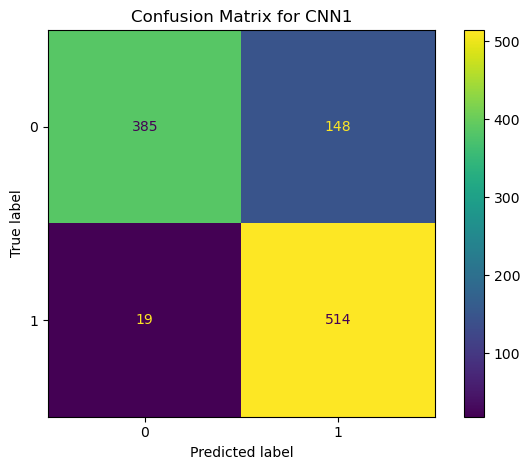

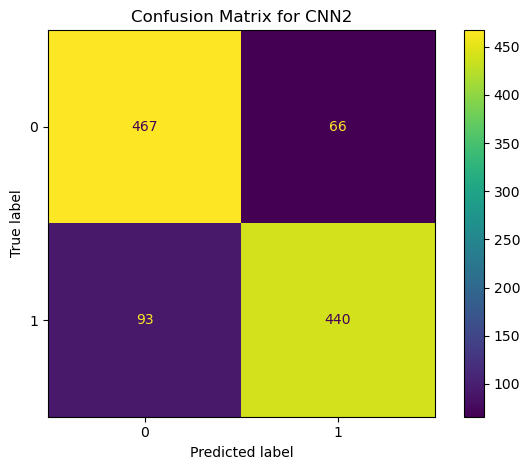

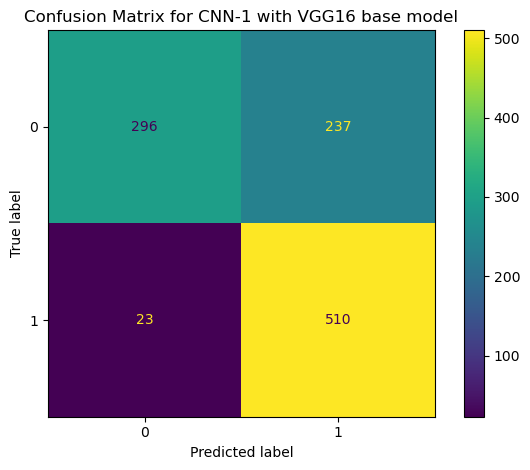

In [181]:
for model, preds in models:
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, (preds > 0.5).astype('int32')))
    disp.plot()
    plt.title(f'Confusion Matrix for {model}')
    plt.tight_layout()
    plt.show()